In [1]:
from loadTestCases import load

In [2]:
load(1, 2)

{'input': {'f': 1000.0, 'inputFile': '../../sounds/sine-1000.wav'},
 'output': (1000.0199030684435, 1101, 2048)}

In [3]:
import numpy as np
from scipy.signal import get_window
import math
import sys, os
sys.path.append('../../software/models/')
import dftModel as DFT
import utilFunctions as UF

""" 
A5-Part-1: Minimizing the frequency estimation error of a sinusoid

Write a function that estimates the frequency of a sinusoidal signal at a given time instant. The 
function should return the estimated frequency in Hz, together with the window size and the FFT 
size used in the analysis.  

The input arguments to the function are the wav file name including the path (inputFile) containing 
the sinusoidal signal, and the frequency of the sinusoid in Hz (f). The frequency of the input sinusoid  
can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated 
frequency of the sinusoid (fEst), the window size (M) and the FFT size (N) used.

The input wav file is a stationary audio signal consisting of a single sinusoid of length >=1 second. 
Since the signal is stationary you can just perform the analysis in a single frame, for example in 
the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select 
a fragment of the signal equal to the window size, M, centered at .5 seconds, then compute the DFT 
using the dftAnal function, and finally use the peakDetection and peakInterp functions to obtain the 
frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold t = -40 dB for peak picking. The window
size and FFT size should be chosen such that the difference between the true frequency (f) and the 
estimated frequency (fEst) is less than 0.05 Hz for the entire allowed frequency range of the input 
sinusoid. The window size should be the minimum positive integer of the form 100*k + 1 (where k is a 
positive integer) for which the frequency estimation error is < 0.05 Hz. For a window size M, take the
FFT size (N) to be the smallest power of 2 larger than M. 

HINT: Computing M theoritically using a formula might be complex in such cases. Instead, you need to 
follow a heuristic approach to determine the optimal value of M and N for a particular f. You can iterate
over all allowed values of window size M and stop when the condition is satisfied (i.e. the frequency
estimation error < 0.05 Hz).

Test case 1: If you run your code with inputFile = '../../sounds/sine-490.wav', f = 490.0 Hz, the optimal
values are M = 1101, N = 2048, fEst = 489.963 and the freqency estimation error is 0.037.

Test case 2: If you run your code with inputFile = '../../sounds/sine-1000.wav', f = 1000.0 Hz, the optimal
values are M = 1101, N = 2048, fEst = 1000.02 and the freqency estimation error is 0.02.

Test case 3: If you run your code with inputFile = '../../sounds/sine-200.wav', f = 200.0 Hz, the optimal
values are M = 1201, N = 2048, fEst = 200.038 and the freqency estimation error is 0.038.
"""
def minFreqEstErr(inputFile, f):
    """
    Inputs:
            inputFile (string) = wav file including the path
            f (float) = frequency of the sinusoid present in the input audio signal (Hz)
    Output:
            fEst (float) = Estimated frequency of the sinusoid (Hz)
            M (int) = Window size
            N (int) = FFT size
    """
    # analysis parameters:
    window = 'blackman'
    t = -40
    min_err = .05
    ### Your code here
    fs, x = UF.wavread(inputFile)
    fEst = M = N = 0
    
    def get_peak(M, N):
        half_sec = int(fs / 2)
        x1 = x[half_sec - int(M / 2):half_sec + int((M + 1) / 2)]
        w = get_window(window, M)
        mX, pX = DFT.dftAnal(x1, w, N)
        ploc = UF.peakDetection(mX, t)
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        est = fs * iploc[0] / N
        return est
    
    for test_M in range(201, 4002, 100):
        test_N = int(2 ** np.ceil(np.log2(test_M)))
        fEst = get_peak(test_M, test_N)
        diff = abs(fEst - f)
        if diff < min_err:
            M = test_M
            N = test_N
            break
    return fEst, M, N

In [4]:
minFreqEstErr(**load(1, 2)['input'])

(1000.0199426780141, 1101, 2048)

Mean estimation error = [ 0.71825828  1.2993951 ] Hz


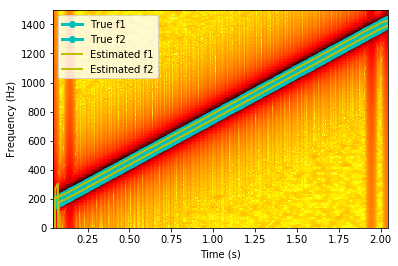

(4096,
 128,
 array([ 0.04643991,  0.0493424 ,  0.0522449 ,  0.05514739,  0.05804989,
         0.06095238,  0.06385488,  0.06675737,  0.06965986,  0.07256236,
         0.07546485,  0.07836735,  0.08126984,  0.08417234,  0.08707483,
         0.08997732,  0.09287982,  0.09578231,  0.09868481,  0.1015873 ,
         0.1044898 ,  0.10739229,  0.11029478,  0.11319728,  0.11609977,
         0.11900227,  0.12190476,  0.12480726,  0.12770975,  0.13061224,
         0.13351474,  0.13641723,  0.13931973,  0.14222222,  0.14512472,
         0.14802721,  0.15092971,  0.1538322 ,  0.15673469,  0.15963719,
         0.16253968,  0.16544218,  0.16834467,  0.17124717,  0.17414966,
         0.17705215,  0.17995465,  0.18285714,  0.18575964,  0.18866213,
         0.19156463,  0.19446712,  0.19736961,  0.20027211,  0.2031746 ,
         0.2060771 ,  0.20897959,  0.21188209,  0.21478458,  0.21768707,
         0.22058957,  0.22349206,  0.22639456,  0.22929705,  0.23219955,
         0.23510204,  0.23800454,  0.2

In [11]:
import numpy as np
from scipy.signal import get_window
import sys, os
sys.path.append('../../software/models/')
import stft
import utilFunctions as UF
import sineModel as SM
import matplotlib.pyplot as plt
""" 
A5-Part-2: Tracking a two component chirp 

Perform a "good" sinusoidal analysis of a two component chirp by specifying the parameter 
window-size in the function chirpTracker() below. The estimation and tracking of the two varying 
frequencies should result in a mean error smaller than 2Hz. The function returns the parameters 
used, true and estimated tracks of frequency components, and their associated time stamps. 

In this part, you will use the sound chirp-150-190-linear.wav, which is a linear chirp with two 
sinusoids of 150Hz and 190 Hz, whose frequency increases in two seconds to 1400Hz and 1440Hz 
respectively. Listen to the sound and use sms-tools GUI or sonic visualizer to see its spectrogram. 

You will not write any additional code in this question, but modify the parameter of the code to 
obtain the best possible results. There are three functions we have written for you. Please go through 
each function and understand it, but do not modify any of it.
1. chirpTracker(): This is the main function. Uses sineModel.py for sinusoidal analysis of the input 
sound. It takes an input audio file and uses the function sineModel.sineModelAnal() to obtain the two 
frequency tracks (fTrackEst) in the chirp and computes the estimation error (meanErr) using the true 
frequency tracks obtained using genTrueFreqTracks().

chirpTracker() calls the following two functions:
2. genTimeStamps(): Generates the time stamps at which the frequencies of sinusoids are estimated (one 
value per frame)
3. genTrueFreqTracks(): For the input sound chirp-150-190-linear.wav, the function generates the true 
frequency values, so that we can compare the true and the estimated frequency values. 

We will use the sinusoidal model to analyse this sound and extract the two components. We will use the 
sineModel.sineModelAnal() function for analysis. The code for analysis is already provided below 
with some parameters we have fixed. For analysis, we will use a blackman window. Since we need only 
two frequency component estimates every frame, we set maxnSines = 2. 

Choose the parameter window-size (M) such that the mean estimation error (meanErr) of each frequency 
component is less than 2 Hz. There is a range of values of M for which this is true and all of those 
values will be considered correct answers. You can plot the estimated and true frequency tracks to 
visualize the accuracy of estimation. 

We have written the function chirpTracker() for you and you just have to edit M. It is marked as XX 
and you can edit its value as needed. 

As an example, choosing M = 1023, the mean estimation error is [13.677,  518.409] Hz, 
which as you can see do not give us the desired estimation errors. 

"""
def chirpTracker(inputFile='../../sounds/chirp-150-190-linear.wav'):
    """
    Input:
           inputFile (string) = wav file including the path
    Output:
           M (int) = Window length
           H (int) = hop size in samples
           tStamps (numpy array) = A Kx1 numpy array of time stamps at which the frequency components were estimated
           fTrackEst (numpy array) = A Kx2 numpy array of estimated frequency values, one row per time frame, one column per component
           fTrackTrue (numpy array) = A Kx2 numpy array of true frequency values, one row per time frame, one column per component
           K is the number of frames
    """
    # Analysis parameters: Modify values of the parameters marked XX
    M = 4096                                # Window size in samples
    
    ### Go through the code below and understand it, do not modify anything ###    
    H = 128                                     # Hop size in samples
    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    t = -80.0                                   # threshold
    window = 'blackman'                         # Window type
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation
    
    fs, x = UF.wavread(inputFile)               # read input sound
    w = get_window(window, M)                   # Compute analysis window
    tStamps = genTimeStamps(x.size, M, fs, H)   # Generate the tStamps to return
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    fTrackTrue = genTrueFreqTracks(tStamps)     # Generate the true frequency tracks
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)     
    print ("Mean estimation error = " + str(meanErr) + ' Hz')      # Print the error to terminal    
    # Plot the estimated and true frequency tracks
    mX, pX = stft.stftAnal(x, w, N, H)
    maxplotfreq = 1500.0
    binFreq = fs*np.arange(N*maxplotfreq/fs)/N
    plt.pcolormesh(tStamps, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]),cmap = 'hot_r')
    plt.plot(tStamps,fTrackTrue, 'o-', color = 'c', linewidth=3.0)
    plt.plot(tStamps,fTrackEst, color = 'y', linewidth=2.0)
    plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.autoscale(tight=True)
    plt.show()
    return M, H, tStamps, fTrackEst, fTrackTrue  # Output returned 

### Do not modify this function
def genTimeStamps(xlen, M, fs, H):
    # Generates the timeStamps as needed for output
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

### Do not modify this function
def genTrueFreqTracks(tStamps):
    # Generates the true frequency values to compute estimation error
    # Specifically to chirp-150-190-linear.wav
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack
    
chirpTracker()

In [22]:
import numpy as np
from scipy.signal import get_window
import sys, os
sys.path.append('../../software/models/')
import stft
import utilFunctions as UF
import sineModel as SM
import matplotlib.pyplot as plt

"""
A5-Part-3: Tracking sinusoids of different amplitudes 

Perform a "good" sinusoidal analysis of a signal with two sinusoidal components of different amplitudes 
by specifying the parameters 'window type' and 'peak picking threshold' in the function mainlobeTracker() 
below. The function should return the parameters used, true and estimated tracks of frequency components, 
and their associated time stamps. 

We will consider a signal that has two sinusoidal components with a very large difference in their 
amplitude. We will use a synthetically generated signal with frequency components 440 Hz and 602 Hz, 
s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t). As you see the amplitude difference is large. You will 
use the sound sines-440-602-hRange.wav. Listen to the sound and use sms-tools GUI or sonic visualizer 
to see its spectrogram. Notice the difference in the amplitudes of its components. 

You will not write any additional code in this question, but modify the parameters of the code to obtain 
the best possible results. There are three functions we have written for you. Please go through each 
function and understand it, but do not modify any of it.
1. mainlobeTracker(): This is the main function. Uses sineModel.py for sinusoidal analysis of the input 
sound. It takes an input audio file and uses the function sineModel.sineModelAnal(), tracks the mainlobes 
of the two sinusoids to obtain the two frequency tracks (fTrackEst) in the signal. It also computes the 
estimation error (meanErr) in frequency using the true frequency tracks obtained using genTrueFreqTracks().

mainlobeTracker() calls the following two functions:
2. genTimeStamps(): Generates the time stamps at which the sinuosid frequencies are estimated (one 
value per audio frame)
3. genTrueFreqTracks(): For the input sound sines-440-602-hRange.wav, the function generates the true 
frequency values, so that we can compare the true and the estimated frequency values. 

We will use sinusoidal Model to analyse this sound and extract the two components. We will use the 
sineModel.sineModelAnal() function for analysis. The code for analysis is already provided below with 
some parameters we have fixed. For analysis, we will use a window length (M) of 2047 samples, an FFT 
size (N) of 4096 samples and hop size (H) of 128 samples. For sine tracking, we set the minimum sine 
duration (minSineDur) to 0.02 seconds, freqDevOffset to 10 Hz and freqDevSlope to its default value of 
0.001. Since we need only two frequency component estimates at every frame, we set maxnSines = 2. 

Choose the parameters window and the peak picking threshold (t) such that the mean estimation error of 
each frequency components is less than 2 Hz. There is a range of values of M and t for which this is 
true and all of those values will be considered correct answers. You can plot the estimated and true 
frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: 
window, t, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window 
might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of 
the low amplitude sinusoid. 

We have written the function mainlobeTracker() and you have to edit the window and t values. For the window, choose 
one of 'boxcar', 'hanning', 'hamming', 'blackman', or 'blackmanharris'. t is specified in negative dB. These two 
parameters are marked as XX and you can edit the values as needed. 

As an example, choosing window = 'boxcar', t = -80.0, the mean estimation error is [0.142, 129.462] Hz. 
"""

def mainlobeTracker(inputFile = '../../sounds/sines-440-602-hRange.wav'):
    """
    Input:
           inputFile (string): wav file including the path
    Output:
           window (string): The window type used for analysis
           t (float) = peak picking threshold (negative dB)
           tStamps (numpy array) = A Kx1 numpy array of time stamps at which the frequency components were estimated
           fTrackEst = A Kx2 numpy array of estimated frequency values, one row per time frame, one column per component
           fTrackTrue = A Kx2 numpy array of true frequency values, one row per time frame, one column per component
    """       
    # Analysis parameters: Modify values of the parameters marked XX
    window = 'blackmanharris'                                    # Window type
    t = -80                                         # threshold (negative dB)
    
    ### Go through the code below and understand it, do not modify anything ###   
    M = 2047                                             # Window size 
    N = 4096                                             # FFT Size
    H = 128                                              # Hop size in samples
    maxnSines = 2
    minSineDur = 0.02
    freqDevOffset = 10
    freqDevSlope = 0.001
    # read input sound
    fs, x = UF.wavread(inputFile)               
    w = get_window(window, M)                   # Compute analysis window
    tStamps = genTimeStamps(x.size, M, fs, H)   # Generate the tStamps to return
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    fTrackTrue = genTrueFreqTracks(tStamps)     # Generate the true frequency tracks
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)     
    print ("Mean estimation error = " + str(meanErr) + ' Hz')      # Print the error to terminal
    # Plot the estimated and true frequency tracks
    mX, pX = stft.stftAnal(x, w, N, H)
    maxplotfreq = 900.0
    binFreq = fs*np.arange(N*maxplotfreq/fs)/N
    plt.pcolormesh(tStamps, binFreq, np.transpose(mX[:,:N*maxplotfreq/fs+1]), cmap='hot_r')
    plt.plot(tStamps,fTrackTrue, 'o-', color = 'c', linewidth=3.0)
    plt.plot(tStamps,fTrackEst, color = 'y', linewidth=2.0)
    plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.autoscale(tight=True)
    return window, float(t), tStamps, fTrackEst, fTrackTrue  # Output returned 

### Do not modify this function
def genTimeStamps(xlen, M, fs, H):
    # Generates the timeStamps as needed for output
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

### Do not modify this function
def genTrueFreqTracks(tStamps):
    # Generates the true frequency values to compute estimation error
    # Specifically to sines-440-602-hRange.wav
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

mainlobeTracker()

Mean estimation error = [ 0.0053099   0.01883719] Hz


TypeError: slice indices must be integers or None or have an __index__ method

In [26]:
import numpy as np
from scipy.signal import get_window
import sys, os
sys.path.append('../../software/models/')
import utilFunctions as UF
import sineModel as SM
import stft
import matplotlib.pyplot as plt

"""
A5-Part-4: Tracking sinusoids using the phase spectrum

Write a function selectFlatPhasePeak() that selects a sinusoid peak based on the flatness of the 
phase spectrum around the frequency of the sinusoid. The function will be used for tracking sinusoids 
in audio signals, as an alternate method to tracking the mainlobe peaks of the magnitude spectrum. 

In this question, you will implement an alternate way of tracking mainlobe of a sinusoid, using the 
phase spectrum. Recall that zero-phase windowing of sinusoid signal frame leads to a phase spectrum 
that is flat around the bins corresponding to frequency of the sinusoid. We will use this property 
of flatness of the phase spectrum as an alternative method to track the sinusoids. Note that this 
condition of flatness is satisfied only when the sinusoid is not time varying. For time-varying 
sinusoids, the condition fails. 

We will consider a signal that has two sinusoid components and has a transient in the middle of the 
audio file. You will use the sound sines-440-602-transient.wav. Listen to the sound and use sms-tools 
GUI or sonic visualizer to see its spectrogram. Notice the transient that occurs in the middle of the 
sound file, where tracking using phase is likely to fail. We also recommend you to use the sms-tools 
GUI and DFT model to plot the spectrum at different parts of the signal to see if you indeed observe 
that the phase spectrum is flat around the sinusoid frequencies. 

We will use sinusoidal model for analysis. We have modified the code in sineModel.sineModelAnal() to 
create a new function sineModelAnalEnhanced() which does a modified sine Tracking based on phase 
spectrum. Once we have the peaks estimated from the magnitude spectrum, we use a phase spectrum flatness 
measure around each peak location to select or reject the peak. 

You will implement the function selectFlatPhasePeak() that checks for the flatness of the phase spectrum 
around the peak location. Given the peak location (p), the positive half of the phase spectrum (pX) and 
a threshold (phaseDevThres), you will compute the standard deviation of 5 samples of pX around the peak 
location (two samples either side and the sample at p itself) and compare it with the threshold. Based 
on the comparison, return a boolean variable selectFlag, which is True if the standard deviation is less 
than the threshold (and hence the phase is flat), else False (phase is not flat). We will use a small 
phase deviation threshold of 0.01 radian. In short, selectFlatPhasePeak() that returns True if the 
standard deviation of five samples of the phase spectrum pX around the input index p is less than the 
given threshold, else False.

Read through the function sineModelAnalEnhanced() and understand it thoroughly before implementing 
selectFlatPhasePeak() function. The function sineModelAnalEnhanced() takes an input audio file and 
uses phase based sinusoid tracking to obtain the two frequency tracks (fTrackEst) in the signal. 
Since we need only two sinusoids every frame, we only consider the frames where we get two selected 
peaks, and ignore the other frames. You can plot the estimated and true frequency tracks to visualize 
the accuracy of estimation (code provided). 

Test case 1: With pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8]), p = 3, and 
phaseDevThres = 0.25, the function selectFlatPhasePeak() returns selectFlag = True. 

Test case 2: With pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8]), p = 3, and 
phaseDevThres = 0.1, the function selectFlatPhasePeak() returns selectFlag = False.

Test case 3: With pX = np.array([2.39, 2.40, 2.40, 2.41, 3.37, 2.45, 2.46, 2.46, 2.29, 1.85, 2.34, 
2.18, 2.93, 2.10, 3.39, 2.41, 2.41, 2.40, 2.40, 2.40, 1.46, 0.23, 0.98, 0.41, 0.37, 0.40, 0.41, 
0.87, 0.51, 0.67]), p = 17, and phaseDevThres = 0.01, the function selectFlatPhasePeak() 
returns selectFlag = True

As an example, when you run sineModelAnalEnhanced(inputFile= './sines-440-602-transient.wav'), if 
you have implemented selectFlatPhasePeak() function correctly, you will see two sinusoid tracks in 
the beginning and end of the audio file, while there are no tracks in the middle of the audio file. 
This is due to the transients present in the middle of the audio file, where phase based tracking of 
sinusoids fails. 

"""

## Complete this function
def selectFlatPhasePeak(pX, p, phaseDevThres):
    """
    Function to select a peak index based on phase flatness measure. 
    Input: 
            pX (numpy array) = The phase spectrum of the frame
            p (positive integer) = The index of peak in the magnitude spectrum
            phaseDevThres (float) = The threshold value to measure flatness of phase
    Output: 
            selectFlag (Boolean) = True, if the peak at index p is a mainlobe, False otherwise
    """
    #Your code here
    return np.std(pX[p-2:p+3]) < phaseDevThres
    

### Go through the code below and understand it, but do not modify anything ###
def sineModelAnalEnhanced(inputFile= '../../sounds/sines-440-602-transient.wav'):
    """
    Input:
           inputFile (string): wav file including the path
    Output:
           tStamps: A Kx1 numpy array of time stamps at which the frequency components were estimated
           tfreq: A Kx2 numpy array of frequency values, one column per component
    """
    phaseDevThres = 1e-2                                   # Allowed deviation in phase
    M = 2047                                               # window size
    N = 4096                                               # FFT size 
    t = -80                                                # threshold in negative dB
    H = 128                                                # hop-size
    window='blackman'                                      # window type
    fs, x = UF.wavread(inputFile)                          # Read input file
    w = get_window(window, M)                              # Get the window
    hM1 = int(np.floor((w.size+1)/2))                      # half analysis window size by rounding
    hM2 = int(np.floor(w.size/2))                          # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                         # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM2))                         # add zeros at the end to analyze last sample
    pin = hM1                                              # initialize sound pointer in middle of analysis window       
    pend = x.size - hM1                                    # last sample to start a frame
    tStamps = np.arange(pin,pend,H)/float(fs)              # Generate time stamps
    w = w / sum(w)                                         # normalize analysis window
    tfreq = np.array([])
    while pin<pend:                                        # while input sound pointer is within sound            
        x1 = x[pin-hM1:pin+hM2]                            # select frame
        mX, pX = SM.DFT.dftAnal(x1, w, N)                  # compute dft
        ploc = UF.peakDetection(mX, t)                     # detect locations of peaks
        ###### CODE DIFFERENT FROM sineModelAnal() #########
        # Phase based mainlobe tracking
        plocSelMask = np.zeros(len(ploc))                  
        for pindex, p in enumerate(ploc):
            if p > 2 and p < (len(pX) - 2):                    # Peaks at either end of the spectrum are not processed
                if selectFlatPhasePeak(pX, p, phaseDevThres):  # Select the peak if the phase spectrum around the peak is flat
                    plocSelMask[pindex] = 1        
            else:
                plocSelMask[pindex] = 1                        
        plocSel = ploc[plocSelMask.nonzero()[0]]               # Select the ones chosen
        if len(plocSel) != 2:                                  # Ignoring frames that don't return two selected peaks
            ipfreq = [0.0, 0.0]
        else:
            iploc, ipmag, ipphase = UF.peakInterp(mX, pX, plocSel) # Only selected peaks to refine peak values by interpolation
            ipfreq = fs*iploc/float(N)                             # convert peak locations to Hertz
        ###### CODE DIFFERENT FROM sineModelAnal() #########
        if pin == hM1:                                        # if first frame initialize output frequency track
            tfreq = ipfreq 
        else:                                                 # rest of frames append values to frequency track
            tfreq = np.vstack((tfreq, ipfreq))
        pin += H
    # Plot the estimated frequency tracks
    mX, pX = stft.stftAnal(x, w, N, H)
    maxplotfreq = 1500.0
    binFreq = fs*np.arange(N*maxplotfreq/fs)/N
    numFrames = int(mX[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs) 
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]), cmap='hot_r')
    plt.plot(tStamps,tfreq[:,0], color = 'y', linewidth=2.0)
    plt.plot(tStamps,tfreq[:,1], color = 'c', linewidth=2.0)
    plt.legend(('Estimated f1', 'Estimated f2'))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.autoscale(tight=True)
    return tStamps, tfreq


(array([ 0.02321995,  0.02612245,  0.02902494, ...,  3.01569161,
         3.0185941 ,  3.0214966 ]), array([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ..., 
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]]))

In [32]:
selectFlatPhasePeak(**load(4, 3)['input'])

True